**Problem Statement**

Financial threats are displaying a trend about the credit risk of commercial banks as the incredible improvement in the financial industry has arisen. In this way, one of the biggest threats faces by commercial banks is the risk prediction of credit clients. The goal is to predict the probability of credit default based on credit card owner's characteristics and payment and ransaction history.

**Approach**

Tasks:- Building Classifier Model using Deep Learning and Machine Learning. 
Supervised Learning tasks (Classification Problem)

   Tools.

1. Tensorflow and Keras API.
2. Sklearn.
3. Matplotlib and Seaborn.
4. MLflow

**Table of Content**
1. Importing Dependencies.
2. Data Understanding.
3. Exploratory Data Analysis.
4. Feature Engineering.
5. Model Building.
6. Model Evaluation and Interpretation

**Loading Dependencies**

In [235]:
import pandas as pd
import numpy as np
from collections import Counter

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report

from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import Callback, EarlyStopping, TensorBoard, ModelCheckpoint

import mlflow
from mlflow.tensorflow import autolog
from mlflow import log_metrics

import shap
from shap import TreeExplainer, force_plot, summary_plot

shap.initjs()

**Data Understanding**

The process of analyzing data is to understand the data and gain useful information so that the derived knowledge can help in decision making.

In [236]:
# loading dataset
df = pd.read_csv('dataset/Churn.csv')

In [237]:
# returns the first five rows
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [238]:
# return a tuple representing the dimensionality of the datasets
df.shape

(10000, 11)

In [239]:
# Count number of distinct elements in specified axis
df.nunique()

CreditScore         460
Geography             3
Gender                2
Age                  70
Tenure               11
Balance            6382
NumOfProducts         4
HasCrCard             2
IsActiveMember        2
EstimatedSalary    9999
Exited                2
dtype: int64

In [240]:
# print a concise summary about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [241]:
# return the sum of Series denoting duplicate rows.
df.duplicated().sum()

0

In [242]:
# return a Series containing counts of default. 
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [243]:
# return the total sum of missing values in present in the dataset 
df.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [244]:
# generate descriptive statistics of the dataset.
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [245]:
# checking relationship i.e correlation of variable in the dataset
corr = df.corr()
corr

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CreditScore,1.000000,-0.003965,0.000842,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
Age,-0.003965,1.000000,-0.009997,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
Tenure,0.000842,-0.009997,1.000000,-0.012254,0.013444,0.022583,-0.028362,0.007784,-0.014001
Balance,0.006268,0.028308,-0.012254,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
NumOfProducts,0.012238,-0.030680,0.013444,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
HasCrCard,-0.005458,-0.011721,0.022583,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
IsActiveMember,0.025651,0.085472,-0.028362,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
EstimatedSalary,-0.001384,-0.007201,0.007784,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097
Exited,-0.027094,0.285323,-0.014001,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000


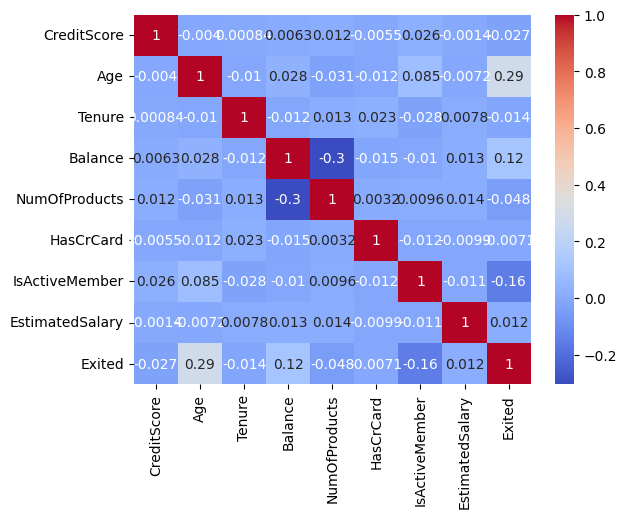

In [246]:
# checking correlation in heatmap
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.show()

**Data visualization is the graphical representation of information and data.**

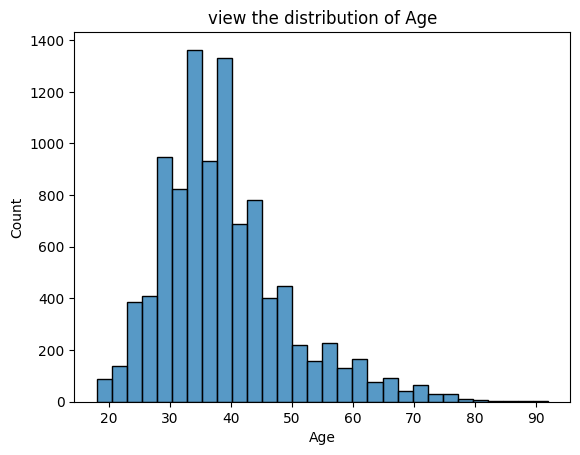

In [247]:
# view the distribution of Age
plt.title('view the distribution of Age')
sns.histplot(data=df, x='Age', bins=30)
plt.show()

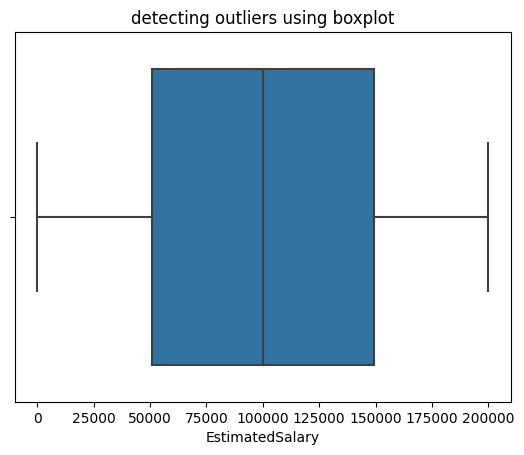

In [248]:
# detecting outliers using boxplot
plt.title('detecting outliers using boxplot')
sns.boxplot(x='EstimatedSalary', data=df)
plt.show()

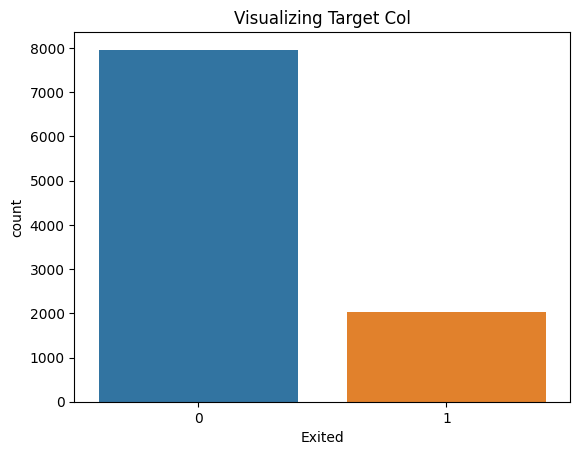

In [249]:
# plotting target col
plt.title('Visualizing Target Col')
sns.countplot(x='Exited', data=df)
plt.show()

**Performing Feature Engineering**

In [250]:
# converting categorical Gender cols to numerical
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

In [251]:
# converting categorical Geography cols to numerical
df['Geography'] = df['Geography'].map({'France': 0, 'Spain': 1, 'Germany': 2})

In [252]:
# drop irrelevant cols
df.drop(['HasCrCard', 'EstimatedSalary', 'Geography', 'Tenure', 'Gender'], axis=1, inplace=True)

In [253]:
# assign independent variables 
x = df.iloc[:, :-1]
# assign dependent variable
y = df.iloc[:, -1]

**Splitting Dataset into Train and Test**

In [254]:
# Split arrays or matrices into random train and test subsets.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=1)

In [255]:
# checking the spread of data
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(6700, 5)
(3300, 5)
(6700,)
(3300,)


**Using Imblearn Library to Handle Data Imbalance present in the Dataset.**

Use the Synthetic Minority Oversampling Technique (SMOTE) which is a statistical technique for increasing the number of cases in your dataset in a balanced way. To data Imbalance present in the dataset.

In [256]:
# outputing y value before over sampling.
counter = Counter(y_train)
print("Before Sampling: {}".format(counter))

# Over-sampling using SMOTE and cleaning using ENN.
sm = SMOTEENN()
# esample the dataset.
x_train_sm, y_train_sm = sm.fit_resample(x_train, y_train)

# outputing y value after over sampling.
counter = Counter(y_train_sm)
print("After Sampling: {}".format(counter))

Before Sampling: Counter({0: 5354, 1: 1346})
After Sampling: Counter({1: 2769, 0: 2276})


In [257]:
# Transform features by scaling each feature to a given range.
sc = MinMaxScaler()
# fit on the training dataset
sc.fit(x_train_sm)

# scale the training datasets
x_train_sm = sc.transform(x_train_sm)
# scale the testing datasets                
x_test = sc.transform(x_test)                                         

**Model Development**

TensorFlow is an open-sourced end-to-end platform, a library for multiple machine learning tasks, while Keras is a high-level neural network library that runs on top of TensorFlow

**Building Customer Churn Prediction Using Neural Network**

In [258]:
# kernel_regularizer=L1L2(l1=1e-3, l2=1e-2), bias_regularizer=L2(1e-4)
# building keras model
def build_model():
    # Sequential groups a linear stack of layers
    model = Sequential([
        Dense(64, activation="relu", input_shape=(5,)),
        Dropout(0.2),
        Dense(128, activation="relu"),
        Dropout(0.3),
        Dense(256, activation="relu"),
        Dropout(0.4),
        Dense(256, activation="relu"),
        Dropout(0.5),
        Dense(128, activation="relu"),
        Dropout(0.5),
        Dense(1, activation="sigmoid")
    ])
    return model

model = build_model()

In [259]:
# Prints a string summary of the network.
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 64)                384       
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_19 (Dense)            (None, 128)               8320      
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_20 (Dense)            (None, 256)               33024     
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_21 (Dense)            (None, 256)              

In [260]:
# Configures the model for training.
model.compile(
    # Gradient descent (with momentum) optimizer.
    optimizer = SGD(learning_rate=0.01, momentum=0.9),
    # Computes the cross-entropy loss between true labels and predicted labels.
    loss=BinaryCrossentropy(),
    # Calculates how often predictions match binary labels.
    metrics=[BinaryAccuracy()])

In [261]:
# model improving.
call_back = [
    # Callback to save the Keras model or model weights at some frequency.
    ModelCheckpoint(filepath="./", monitor="val_loss", save_best_only=True, save_weights_only=True, mode="max"),
    # TensorBoard is a visualization tool provided with TensorFlow.
    TensorBoard(log_dir='./logs', update_freq=1),
    # Stop training when a monitored metric has stopped improving.
    EarlyStopping(monitor='val_loss', patience=20, mode='min', restore_best_weights=True)
]

In [262]:
# Set the given experiment as the active experiment. 
mlflow.set_experiment("Churn Prediction")

# Start a new MLflow run
with mlflow.start_run(): 
    # Enables automatic logging
    autolog()
    
    # Trains the model for a fixed number of epochs (iterations on a dataset).
    history = model.fit(x_train_sm, y_train_sm, batch_size=64, epochs=50, callbacks=call_back, validation_data=(x_test, y_test))
    
    # Saves a model as a TensorFlow SavedModel or HDF5 file.
    save_model(model, filepath="model.h5")
    
    # Loads a model saved
    loaded_model = load_model(filepath="model.h5")

    # Generates output predictions for the x_test input sample.
    pred = loaded_model.predict(x_test)
    
    # Returns the loss value & metrics values for the model in test mode.
    _, acc = loaded_model.evaluate(x_train_sm, y_train_sm, batch_size=128, verbose=0)
    print("Train Accuracy: {:.2f}".format(acc*100))

    # Returns the loss value & metrics values for the model in test mode.
    _, acc = loaded_model.evaluate(x_test, y_test, batch_size=128, verbose=0)
    print("Test Accuracy: {:.2f}".format(acc*100))
    
    metric = {
        "Training Accuracy": acc,
        "Testing Accuracy": acc
    }
    # Log multiple metrics for the current run
    log_metrics(metric)
    
# End an active MLflow run
mlflow.end_run()

Epoch 1/50
79/79 [==============================] - 8s 62ms/step - loss: 0.6874 - binary_accuracy: 0.5423 - val_loss: 0.7496 - val_binary_accuracy: 0.2094
Epoch 2/50
79/79 [==============================] - 3s 34ms/step - loss: 0.6628 - binary_accuracy: 0.6137 - val_loss: 0.6841 - val_binary_accuracy: 0.5721
Epoch 3/50
79/79 [==============================] - 3s 36ms/step - loss: 0.5846 - binary_accuracy: 0.7225 - val_loss: 0.6860 - val_binary_accuracy: 0.6442
Epoch 4/50
79/79 [==============================] - 3s 36ms/step - loss: 0.5278 - binary_accuracy: 0.7558 - val_loss: 0.7433 - val_binary_accuracy: 0.6164
Epoch 5/50
79/79 [==============================] - 3s 32ms/step - loss: 0.5017 - binary_accuracy: 0.7691 - val_loss: 0.6491 - val_binary_accuracy: 0.6658
Epoch 6/50
79/79 [==============================] - 3s 36ms/step - loss: 0.4948 - binary_accuracy: 0.7742 - val_loss: 0.7193 - val_binary_accuracy: 0.6152
Epoch 7/50
79/79 [==============================] - 3s 35ms/step - los

In [263]:
y_hat = [1 if i > 0.5 else 0 for i in pred]

In [264]:
# Build a text report showing the main classification metrics.
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.93      0.63      0.75      2609
           1       0.37      0.82      0.51       691

    accuracy                           0.67      3300
   macro avg       0.65      0.73      0.63      3300
weighted avg       0.81      0.67      0.70      3300



In [265]:
# Compute confusion matrix to evaluate the accuracy of a classification.
con_matrix = pd.DataFrame(confusion_matrix(y_test, y_hat), 
                          index=["Actual: No", "Actual: Yes"],
                          columns=("Predicted: No", "Predicted: Yes"))
print(con_matrix)

             Predicted: No  Predicted: Yes
Actual: No            1641             968
Actual: Yes            123             568


In [266]:
# Compute the F1 score
print(f1_score(y_test, y_hat))

0.5101032779524024


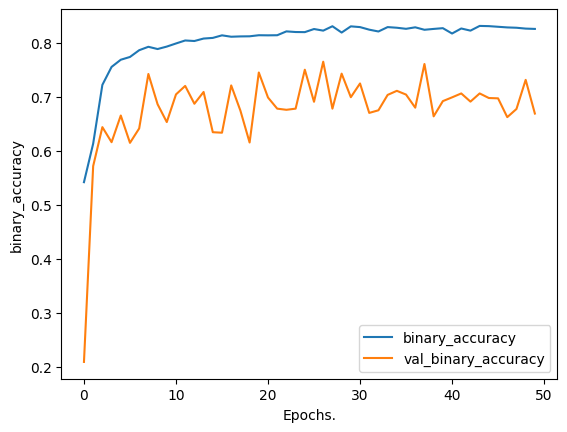

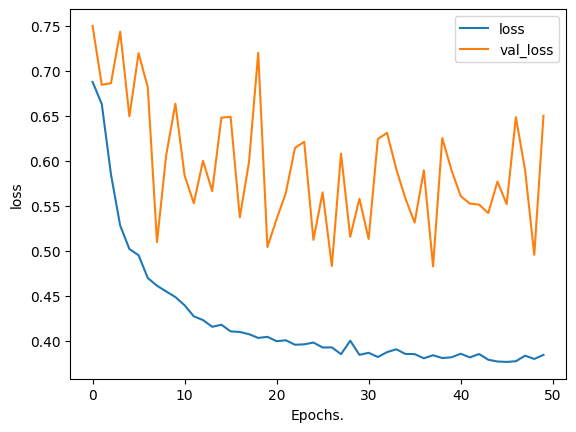

In [267]:
# plotting model peformance
def plot_graph(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history["val_"+string])
    plt.xlabel("Epochs.")
    plt.ylabel(string)
    plt.legend([string, "val_"+string])
    plt.show()

# Model Accuracy Performance 
plot_graph(history, "binary_accuracy")
# Model Validation Performance
plot_graph(history, "loss")

**Building Customer Churn Prediction Using Machine Learning Algorithm.**

1. LightGBM

In [268]:
# Construct a gradient boosting model.
lg = LGBMClassifier()

In [269]:
# K-Folds cross-validator
kfd = KFold(n_splits=8, shuffle=True, random_state=2)

# specifying parameters
para_grid = {
    'learning_rate': [1e-3, 1e-4],
    'n_estimators' : [55, 75]
} 

# Search over specified parameter values with successive halving.
search = GridSearchCV(estimator=lg, param_grid=para_grid, cv=kfd, scoring='accuracy')
# Run fit with all sets of parameters.
search.fit(x_train_sm, y_train_sm)

GridSearchCV(cv=KFold(n_splits=8, random_state=2, shuffle=True),
             estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.001, 0.0001],
                         'n_estimators': [55, 75]},
             scoring='accuracy')

In [270]:
# getting the best model
search.best_estimator_

LGBMClassifier(learning_rate=0.001, n_estimators=55)

In [271]:
# Construct a gradient boosting model.
lg_model = LGBMClassifier(learning_rate=0.001, n_estimators=500)

In [272]:
# Build a gradient boosting model from the training set
lg_model.fit(x_train_sm, y_train_sm)

LGBMClassifier(learning_rate=0.001, n_estimators=500)

In [273]:
# Return the predicted value for each sample.
ypred = lg_model.predict(x_test)

In [274]:
# Build a text report showing the main classification metrics.
print(classification_report(y_test, ypred))

# Compute confusion matrix to evaluate the accuracy of a classification.
con_matrix = pd.DataFrame(confusion_matrix(y_test, ypred), 
                          index=["Actual: No", "Actual: Yes"],
                          columns=("Predicted: No", "Predicted: Yes"))
print(con_matrix)

              precision    recall  f1-score   support

           0       0.93      0.62      0.74      2609
           1       0.37      0.83      0.51       691

    accuracy                           0.66      3300
   macro avg       0.65      0.72      0.63      3300
weighted avg       0.81      0.66      0.69      3300

             Predicted: No  Predicted: Yes
Actual: No            1618             991
Actual: Yes            120             571


**Explaining Model Using Shap Library**

In [275]:
# Uses Tree SHAP algorithms to explain the output of ensemble tree models.
explainer = TreeExplainer(lg_model, x_train_sm)
# Estimate the SHAP values for a set of samples.
shape_values = explainer.shap_values(x_test)

100%|===================| 3289/3300 [02:33<00:00]        

In [279]:
features = [
    'CreditScore', 'Age', 'Balance', 'NumOfProducts', 'IsActiveMember', 
]

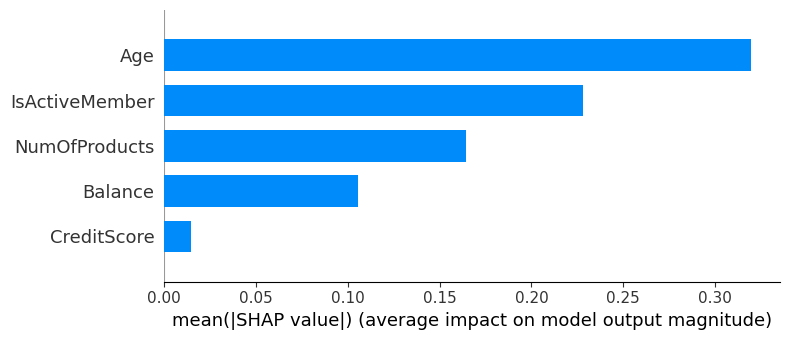

In [280]:
# Create a SHAP beeswarm plot, colored by feature values when they are provided.
summary_plot(shape_values, x_test, feature_names = features, plot_type='bar')

In [281]:
# Visualize the given SHAP values with an additive force layout.
force_plot(explainer.expected_value, shape_values[0, :], x_test[0, :], feature_names = features)